# Text input


## As predictor

In [ ]:
dataset = pd.read_csv("../code/artemis/artemis/data/artemis_preprocessed.csv")
subset = dataset[dataset.split == "test"]

In [ ]:
a=torch.rand((10000,512)).to(device)
slp_vit.to(device)
b = slp_vit(a).softmax(1).argmax(1)

In [ ]:
pd.value_counts(b.tolist())

2    6768
4    1440
5    1109
6     438
7     229
0       7
8       7
1       2
dtype: int64

In [ ]:
clip_RN50x16, _ = clip.load("RN50x16")
clip_RN50x16.eval()

In [ ]:
    clip_RN50x16.encode_text(clip.tokenize([subset.utterance_spelled[0]]).to(device)).shape

torch.Size([1, 512])

In [ ]:
with torch.no_grad():
    res = slps["RN50x16"].model(clip_RN50x16.encode_text(clip.tokenize([subset.utterance_spelled[1]])
                                                         .to(device)))

KeyError: 1

In [ ]:
with torch.no_grad():
    subset["emotion_pred"] = subset\
        .utterance_spelled\
        .map(lambda y : slps["RN50x16"].model(clip_RN50x16.encode_text(clip.tokenize([y]).to(device))).argmax())
    subset.emotion_pred = subset.emotion_pred.map(lambda y : y.detach().cpu().numpy())
    (subset["emotion_label"] == subset["emotion_pred"]).sum()

/tmp/ipykernel_3236/981616719.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/robin/miniconda/envs/py38/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
slps["RN50x16"].get_last_metrics()[]

In [ ]:
((subset["emotion_label"] == subset["emotion_pred"]).sum()/len(subset.index))*100

39.570890840652446

In [ ]:
mat = ct.confusion_matrix(y_true=subset["emotion_label"], y_pred = subset["emotion_pred"])


<Figure size 432x288 with 0 Axes>

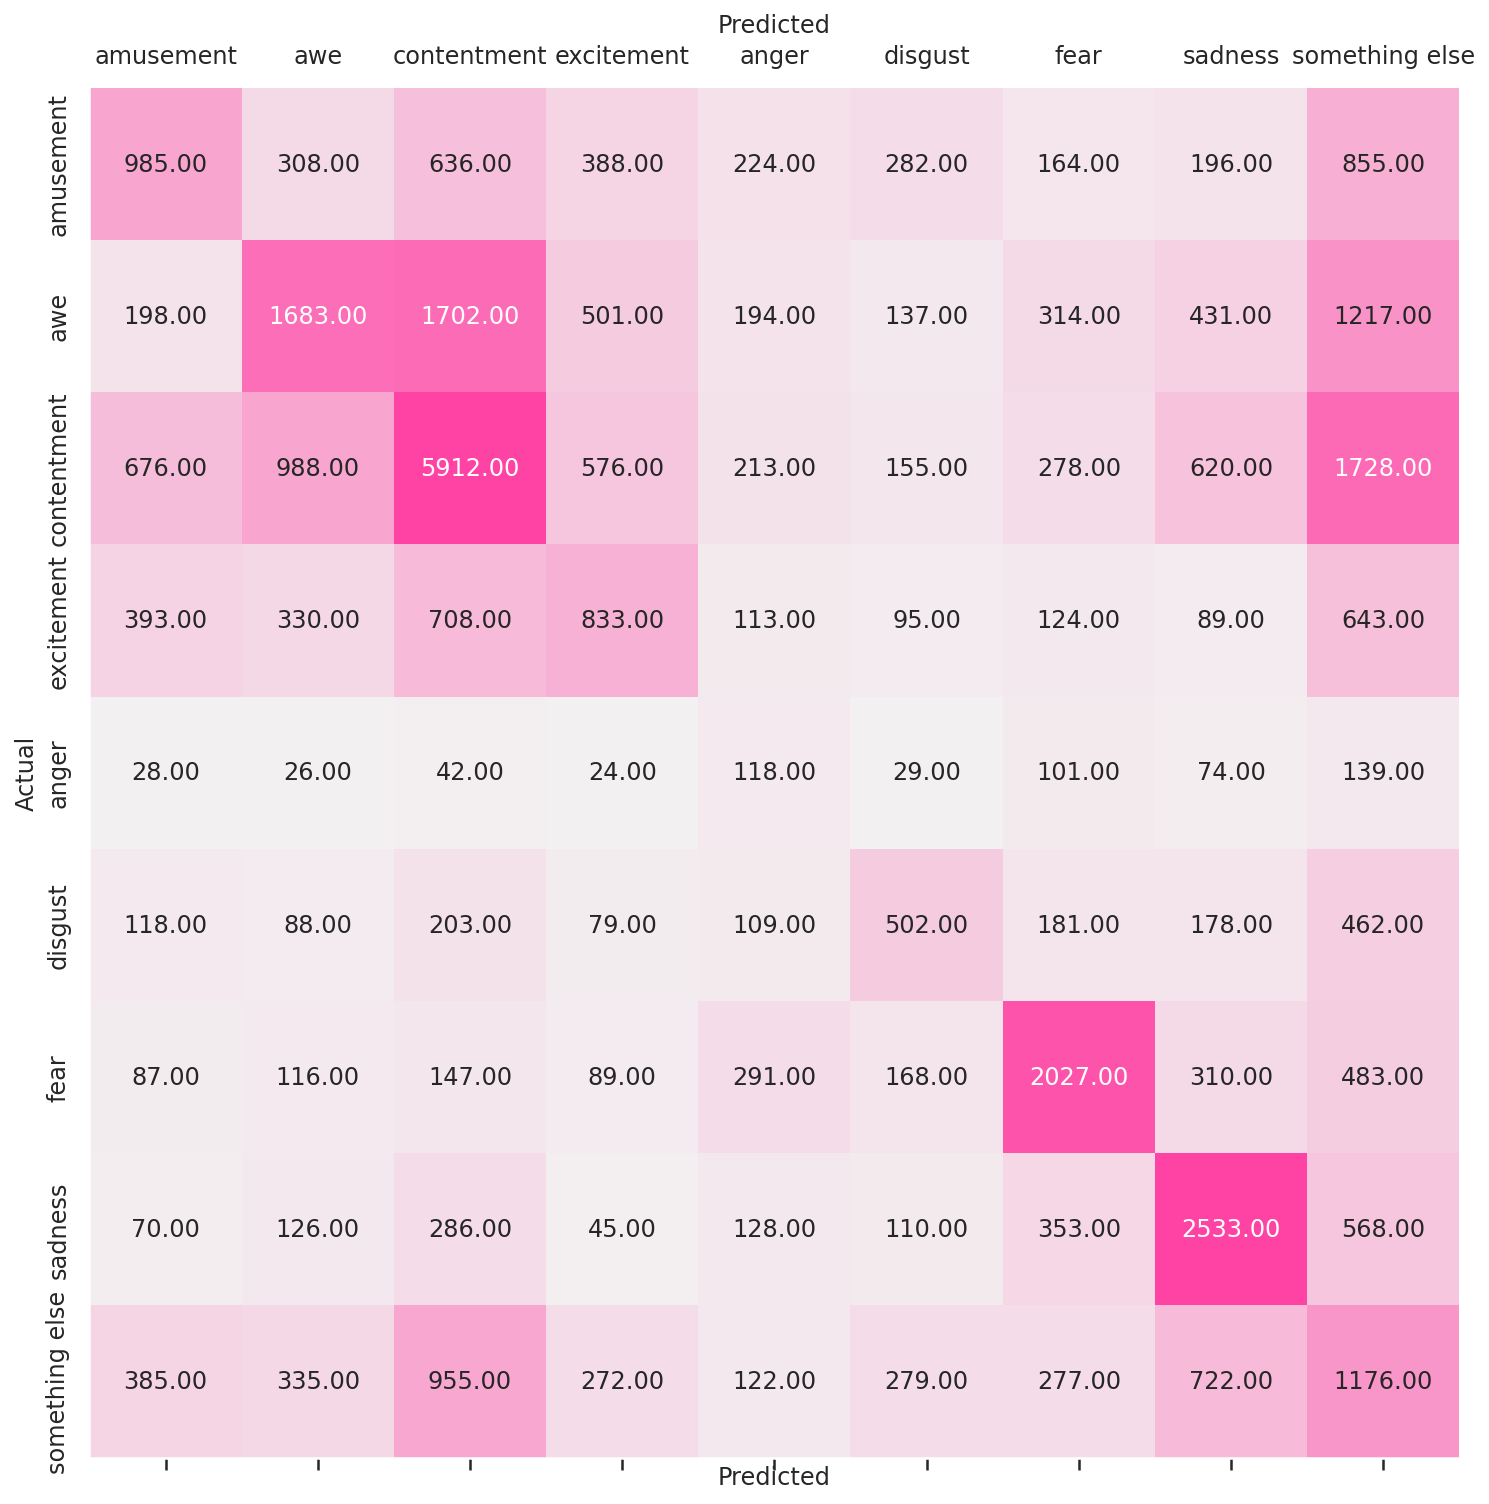

In [ ]:
ct.plot_confusion_matrix(pd.DataFrame(mat, columns=ARTEMIS_EMOTIONS, index = ARTEMIS_EMOTIONS))

## Text most corresponding to a direction

In [329]:
sentences = dataset.utterance

In [330]:
dataset_eq = dataset.groupby("emotion").sample(100)

In [331]:
architecture = "RN50x16"
text_encoder, _ = clip.load("RN50x16", jit=True)

In [332]:
sentences = dataset_eq.utterance
sentences = sentences.map(clip.tokenize)
sentences.head()

16659     [[tensor(49406), tensor(8159), tensor(1710), t...
161284    [[tensor(49406), tensor(518), tensor(18501), t...
321354    [[tensor(49406), tensor(518), tensor(1237), te...
164975    [[tensor(49406), tensor(328), tensor(2051), te...
27641     [[tensor(49406), tensor(328), tensor(1331), te...
Name: utterance, dtype: object

In [333]:
s = torch.cat(sentences.to_list())

In [334]:
with torch.no_grad():
    res = text_encoder.encode_text(s)

In [335]:
res.shape

torch.Size([900, 768])

In [336]:

MODEL_PATH = osp.join("../neural_checkpoints/clip_training/", architecture, "model_9")
model = SLP(input_size=768)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()


SLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=9, bias=True)
  )
)

In [23]:
maxed = model(res).softmax(0).argmax(0)

In [44]:
dataset_eq.head(2)

,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label
52087,Art_Nouveau_Modern,eugã¨ne-grasset_suzy-deguez,amusement,looks to be an early form of pornography done ...,6,train,"['looks', 'to', 'be', 'an', 'early', 'form', '...",13,looks to be an early form of pornography done ...,"[1, 120, 14, 91, 275, 392, 1545, 64, 8557, 738...",0
219369,Baroque,jacob-jordaens_portrait-of-a-lady-sitting-in-a...,amusement,The puffy white collar around the woman's neck...,6,val,"['the', 'puffy', 'white', 'collar', 'around', ...",11,the puffy white collar around the woman 's nec...,"[1, 9, 715, 501, 2803, 130, 9, 21, 118, 2306, ...",0


In [376]:
max_sentences = []
for i, emotion in enumerate(ARTEMIS_EMOTIONS):
    v, indices = model(res).softmax(1)[:,i].topk(3)
    for i,indice in enumerate(indices) :
        max_sentences.append([emotion, round(v[i].data.tolist()*100),dataset_eq.emotion.iloc[indice.numpy()],dataset_eq.utterance.iloc[indice.numpy()]])
        a = dataset_eq[["emotion", "utterance"]].iloc[indices.numpy()]
        #print(round(v[i].data.tolist()*100))
        #print(f"{dataset_eq.emotion.iloc[indice.numpy()]},",dataset_eq.utterance.iloc[indice.numpy()])
sentences = pd.DataFrame(max_sentences, columns = ["Predicted", "Confidence", "Actual", "Description"]).set_index(["Predicted", "Description"])
save_latek("../results/tables/softmax_sentences.tex", sentences.to_latex(multirow = True))

In [368]:
preds_fm = model(res).softmax(1)

In [ ]:
max_sentences = []
for i, emotion in enumerate(ARTEMIS_EMOTIONS):
    v, indices = model(res)[:,i].topk(3)
    for indice in indices :
        max_sentences.append([emotion, round(preds_fm[indice, i].data.tolist()*100),dataset_eq.emotion.iloc[indice.numpy()],dataset_eq.utterance.iloc[indice.numpy()]])
        a = dataset_eq[["emotion", "utterance"]].iloc[indices.numpy()]
        print(round(preds_fm[indice, i].data.tolist()*100))
        print(f"{dataset_eq.emotion.iloc[indice.numpy()]},",dataset_eq.utterance.iloc[indice.numpy()])
sentences = pd.DataFrame(max_sentences, columns = ["Predicted", "Confidence", "Actual", "Description"]).set_index(["Predicted", "Description"])
save_latek("../results/tables/maxed_sentences.tex", sentences.to_latex(multirow = True))

In [381]:
sentences.reset_index().Description.map(lambda y : )

0     I am amused by this fellow's shappy clothes an...
1     It's fun to see all of the people looking like...
2     This woman clearly doesn't take much from anyo...
3     This is awe-inspiring - the subject reaching f...
4     The colors look biblical and the picture remin...
5                    religious awe and woe combine here
6     I love the serenity of the painting, makes me ...
7     This looks like such a relaxing day out; these...
8     The muted pastel colors reminds you of taking ...
9     The bright colors against the black background...
10    I love how the colors seem to be exploding out...
11    The commotion and different colors looks like ...
12    It makes me angry that this man is pointing a ...
13    The guy with the angry look on his face is abo...
14    This is just red, a color that tends to invoke...
15    The man looks like his left eye is pulled out ...
16    looks like the balls from a ball pit from chuc...
17    The abstract art is interesting and leaves

In [364]:
sentences

Confidence  \
Predicted      Description                                                      
amusement      The smiling lady and the dancing lady look like...         508   
               It's fun to see all of the people looking like ...         376   
               I am amused by this fellow's shappy clothes and...         352   
awe            A family of higher status in the 1700 hundreds....         315   
               This is awe-inspiring - the subject reaching fo...         272   
               Heavenly visitors while young ladies contemplat...         252   
contentment    The nurturing mother and child image set in a l...         591   
               The pastel blues from the water and greens from...         571   
               Heavenly visitors while young ladies contemplat...         500   
excitement     The bright colors against the black background ...         792   
               The smiling lady and the dancing lady look like...         448   
               The colors feel warm, bright and energetic whil...         317   
anger          It makes me angry that this man is pointing a g...         703   
               This man looks sad and angry. I think is beard ...         537   
               The guy with the angry look on his face is abou...         535   
disgust        These animals look scary and confusing based on...         319   
               Odd but interesting painting of a nude woman la...         315   
               The man looks like his left eye is pulled out o...         238   
fear           The sky is gloomy and the trees are giving off ...        1090   
               The darkness and her expression give an impress...         903   
               The forest appears dark, with a path leading in...         884   
sadness        The woman looks rather sad with her forlorn exp...        1327   
               This painting, with it's gray palate and lack o...        1286   
               A solemn looking but pretty young African woman...        1156   
something else Cows and horses graze peacefully in the sunlight           347   
               it looks like a very sad boat, and if a boat is...         225   
               The detail of this mans face, his features, eve...         215   

                                                                           Actual  
Predicted      Description                                                         
amusement      The smiling lady and the dancing lady look like...       amusement  
               It's fun to see all of the people looking like ...       amusement  
               I am amused by this fellow's shappy clothes and...       amusement  
awe            A family of higher status in the 1700 hundreds....             awe  
               This is awe-inspiring - the subject reaching fo...             awe  
               Heavenly visitors while young ladies contemplat...             awe  
contentment    The nurturing mother and child image set in a l...     contentment  
               The pastel blues from the water and greens from...  something else  
               Heavenly visitors while young ladies contemplat...             awe  
excitement     The bright colors against the black background ...      excitement  
               The smiling lady and the dancing lady look like...       amusement  
               The colors feel warm, bright and energetic whil...      excitement  
anger          It makes me angry that this man is pointing a g...           anger  
               This man looks sad and angry. I think is beard ...           anger  
               The guy with the angry look on his face is abou...           anger  
disgust        These animals look scary and confusing based on...            fear  
               Odd but interesting painting of a nude woman la...  something else  
               The man looks like his left eye is pulled out o...         disgust  
fear           The sky is gloomy and 

In [ ]:
from visual import 

In [85]:
with pd.option_context("max_colwidth", 1000):
    #display(a)
    print(a.to_latex())

\begin{tabular}{lll}
\toprule
{} &         emotion &                                                                                                                                                    utterance \\
\midrule
19417  &         sadness &                                                                            The bustling port draped in fog makes it seem like the ship coming in is a ghost. \\
305848 &         sadness &                                      At first I thought these were fishing boats, but there are too many people. It looks like lifeboats from a sunken ship. \\
319764 &  something else &                                                                                                looks like a college professor who buys pot from his students \\
62372  &            fear &  nowhere to hide in this stark desert for the person, no doubt in this bare desert the leopard is always hungry, the vultures wait their turn on the horizon \\
421165 &     contentment &    

In [ ]:
dataset_eq.emotion.iloc[indice.numpy()]

In [75]:
dataset_eq.emotion.iloc(indice.tolist())

ValueError: No axis named 82 for object type Series

In [71]:
dataset_eq[["emotion", "utterance"]]

,emotion,utterance
52087,amusement,looks to be an early form of pornography done ...
219369,amusement,The puffy white collar around the woman's neck...
417818,amusement,Her head is cocked as if in disapproval and sh...
87524,amusement,it looks like a busy place everyone is on a mi...
287950,amusement,Her outfit matches and blends in with the frui...
...,...,...
168994,something else,The child like techniques in this painting is ...
382460,something else,Beautiful blue waters and a fluffy white beac...
268016,something else,This man's facial expression feels like he is ...
400835,something else,the lack of color and structure gives me a bor...


In [68]:
indice.tolist()

205

In [24]:
for i, emotion in enumerate(ARTEMIS_EMOTIONS):
    print(emotion, dataset.utterance[int(maxed[i])])

amusement I cannot get over how ridiculous the woman's hairstyle looks. It is so weird!
awe The man is relaxing at his desk, which he considers his domain
contentment The people have very stern looks on their faces and the man in the boat feels like he is being banished.
excitement I cannot get over how ridiculous the woman's hairstyle looks. It is so weird!
anger The colors look like candy pieces all along the mountain
disgust Clear Proof: Bigfoot can be clearly spotted on the lower left between the left most tree and the second tree from the left in the dark shadows behind the bushes.
fear The white flowers look like they would have a lovely scent.
sadness Grey clouds make it look like a storm approaches the boats.
something else The aerial shot of the rocks offers a great view


tensor([[49406,  1043,  4453,  1070,   900,   530,   518,  1674,   267,   537,
           592,  1280,   531,  1038,   768,   768,   533,  2403,   518,  3490,
           269, 49407,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

In [53]:
text_encoderrt sys
sys.getsizeof(s.tolist())

8056

In [ ]:
step = 40
size =len(s)
n_chunks, rest = divmod(size,step)
encoded = torch.tensor([])
for i in range(n_chunks-1):
    encoded = torch.cat([encoded, text_encoder((s[i*step:(i+1)*step]).to(device)).cpu()])
encoded = torch.cat([encoded, text_encoder(s[-rest])])

In [44]:
text_encoder(s.to(device))

RuntimeError: CUDA out of memory. Tried to allocate 226.00 MiB (GPU 0; 31.75 GiB total capacity; 28.69 GiB already allocated; 100.00 MiB free; 30.34 GiB reserved in total by PyTorch)

In [46]:
torch.cuda.empty_cache()

In [47]:
!gpustat

rszymczak-0-0            Sun Jan  9 18:03:16 2022  495.29.05
[0] Tesla V100-SXM2-32GB | 35'C,   0 % | 32410 / 32510 MB |
